# Feature analysis - Montly averages of soil moisture

# Environment Setup

Run the following code box to set the working directories and packages necessary for this workflow 

In [1]:
import os 
import datetime
import glob
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from scipy import stats
import sys
sys.path.append(os.path.join('..', 'SOMOSPIE', 'code', 'analysis'))
import ranking

plt.rcParams['figure.titlesize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

HOME=Path.home()
SOMOSPIE=str(HOME)+"/SOMOSPIE/SOMOSPIE"
os.chdir (SOMOSPIE)
DATA=str(SOMOSPIE)+"/data"
print ("Our working directory is:")
%pwd

Our working directory is:


'/home/exouser/SOMOSPIE/SOMOSPIE'

## Feature analysis involving target variable (soil moisture)
This notebook currently supports feature analysis for soil moisture data fetched from ESA CCI version 7.1 (0.25 degrees resolution) combined with 15 terrain parameters (1km resolution) for the Midwest and West regions. Monthly averages of soil moisture are available for years between 2010 and 2012.

In this case, geographic coordinates are excluded from the analysis (x, y).

**Options**:
* Region: midwest, west 
* Year: 2010 - 2012 
* Methods (Linear Regression, Univariate Linear Regression, Mutual Information, Random Forest): 'LR', 'ULR', 'MI', 'RF'

In [2]:
# Select options: 
region = 'midwest'
year = '2010'
methods = ['ULR', 'MI', 'RF']

In [3]:
# Folder with monthly averages of one year
train_folder = os.path.join(DATA, 'csv_files', region, "train_monthly", year)
train_files = sorted(glob.glob(train_folder + "/*.csv")) # Training files for each month in order

months = range(0, 12)
month_names = [datetime.datetime.strptime(str(month + 1), "%m").strftime("%b") for month in months]

In [4]:
# Iterate over training files and compute scores between each feature and soil moisture values.
training_files_summary = []

for train_file, month, month_name in zip(train_files, months, month_names):
    data = pd.read_csv(os.path.join(train_file))
    data.columns = ['x', 'y', 'z','Hillshading', 'Aspect', 'Channel Network Base Level', 'Channel Network Distance', 'Closed Depressions', 'Convergence Index', 'Elevation', 'LS Factor', 'Plan Curvature', 'Profile Curvature','Relative Slope Position', 'Slope', 'TWI', 'Total Catchment Area', 'Valley Depth']
    
    #To use only 15 terrain parameters and disregard coordinates
    X = data.drop(columns=['x', 'y', 'z'])
    Y = data['z']
    
    if month == months[0]:
        scores = np.zeros((X.columns.shape[0],len(months), len(methods))) # Dimensions (features, months, methods)
        rfe_ranking = np.zeros((X.columns.shape[0],len(months))) 
    
    # Feature normalization
    ss = StandardScaler()
    X_scaled = ss.fit_transform(X)

    scores[:, month,:] = ranking.get_scores(X_scaled, Y, methods)
    training_files_summary.append([month_name, X.shape[0]])
    
    # RECURSIVE FEATURE ELIMINATION
    reg = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=0)
    rfe = RFE(estimator=reg, n_features_to_select=1, step=1)
    rfe.fit(X_scaled, Y)
    rfe_ranking[:, month] = rfe.ranking_

In [5]:
# Training file sizes
training_files_df = pd.DataFrame(training_files_summary, columns=['Month', 'No. of points'])
print('Number of points per training file ({}, {})'.format(region, year))
#df.to_string(index = False)
training_files_df

Number of points per training file (midwest, 2010)


,Month,No. of points
0,Jan,448
1,Feb,448
2,Mar,448
3,Apr,448
4,May,448
5,Jun,448
6,Jul,448
7,Aug,448
8,Sep,448
9,Oct,448


In [6]:
# Feature names abreviation for visualization purposes
feature_names = np.array(['Hill', 'Asp', 'CNBL', 'CND', 'CD', 'CI', 'Ele', 'LSF', 'PlCu', 'PrCu', 'RSP', 'Slo', 'TWI', 'TCA', 'VD'])
#features_names = X.columns.values

In [7]:
# Lookup table for abreviations
lookup_table = pd.DataFrame({'Abreviation': feature_names, 'Features': X.columns.values})

lookup_table['legend'] = lookup_table[['Abreviation', 'Features']].apply(lambda row: ' : '.join(row.values.astype(str)), axis=1)
lookup_table.drop(columns=['legend'])

,Abreviation,Features
0,Hill,Hillshading
1,Asp,Aspect
2,CNBL,Channel Network Base Level
3,CND,Channel Network Distance
4,CD,Closed Depressions
5,CI,Convergence Index
6,Ele,Elevation
7,LSF,LS Factor
8,PlCu,Plan Curvature
9,PrCu,Profile Curvature


## Ranking Plots
To visualize how each method ranks each feature from highest score to lowest score. Each feature is represented by a color.

### Ranking comparison by month

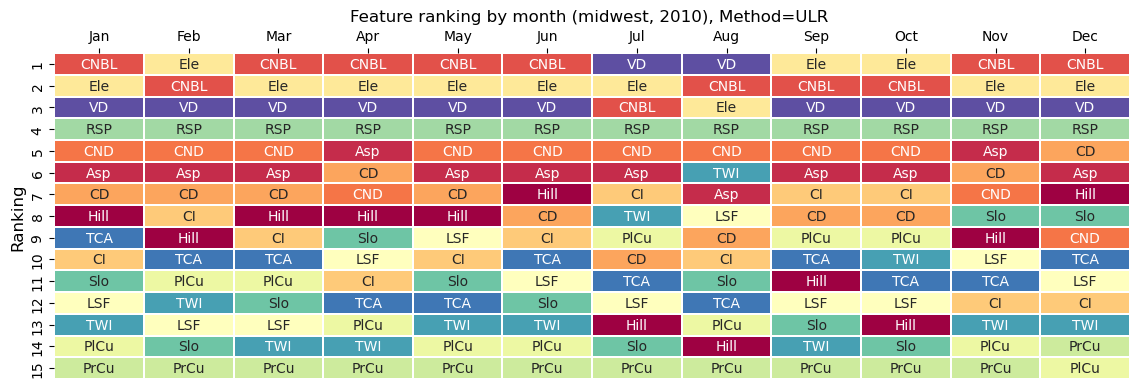

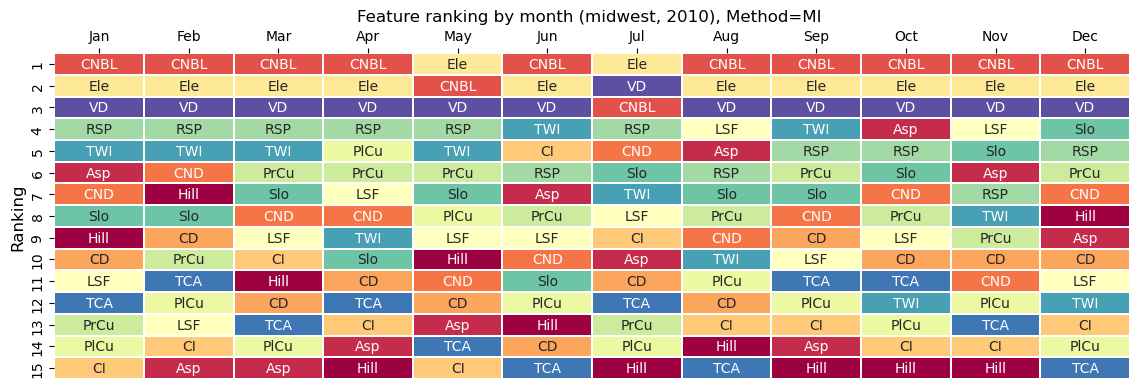

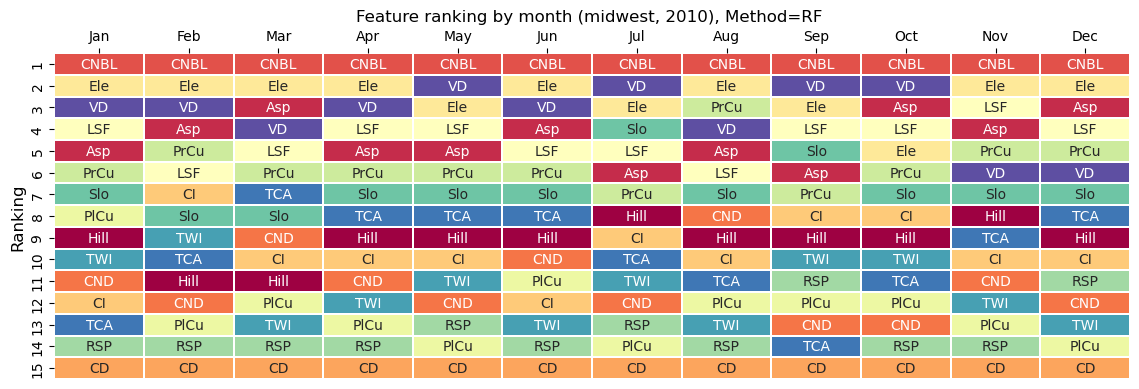

In [8]:
for i, method in enumerate(methods):
    title = 'Feature ranking by month ({}, {}), Method={} '.format(region, year, method)
    ranking.plot_ranking(feature_names, scores[:,:,i], month_names, fig_title=title)

### Ranking comparison by method

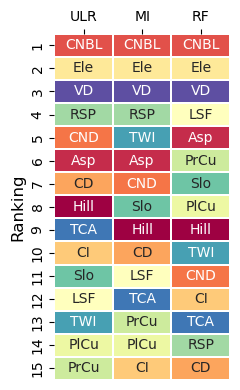

In [9]:
#results_folder = os.path.join(DATA, 'feature_analysis', region, year)
#Path(results_folder).mkdir(parents=True, exist_ok=True)
#filename = 'ranking' + '{0:02d}'.format(month)

for month in months:
    title = 'Feature ranking by method ({}, {}/{})'.format(region, month + 1, year)
    ranking.plot_ranking(feature_names, scores[:,month,:], methods, title, '')
    break

### Averaged scores

In [10]:
# Average scores over time
avg_scores_time = scores.mean(axis=1)
avg_scores_method = scores.mean(axis=2)

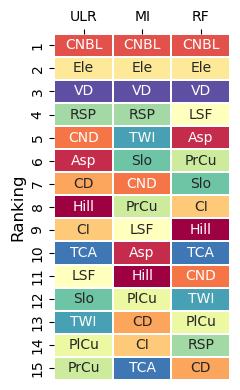

In [11]:
title = 'Feature ranking, scores averaged over time ({}, {})'.format(region, year)
ranking.plot_ranking(feature_names, avg_scores_time, methods, title, '')

## Ranking by Recursive Feature Elimination

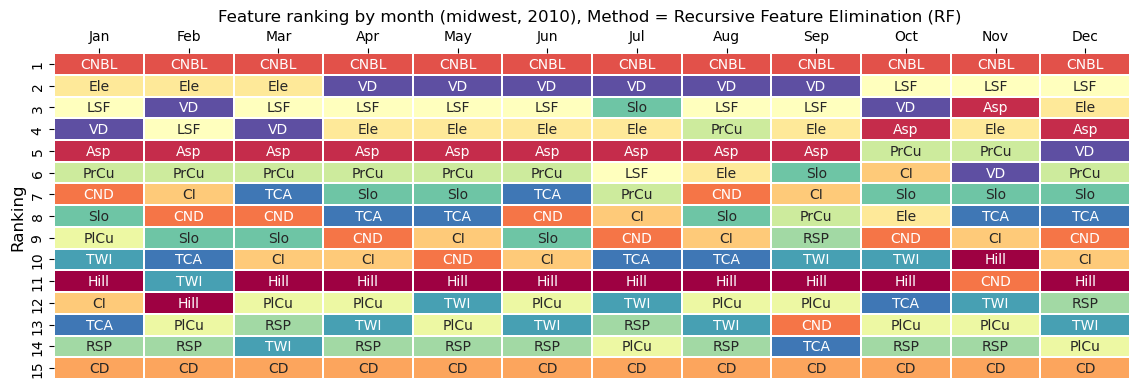

In [12]:
title = 'Feature ranking by month ({}, {}), Method = Recursive Feature Elimination (RF) '.format(region, year, method)
ranking.plot_ranking(feature_names, rfe_ranking, month_names, descending=False, fig_title=title)

## Score Plots
To visualize the distribution of scores given by each method to each feature accross time.

* Adaptive y-axes (None) or user defined y-axes(for each method): [None, None, None] or [[ymin, ymax], [ymin, ymax], [ymin, ymax]]
* Shading (to differentiate between months): True or False.
* Shading interval (could be changed to 3 if seasons want to be highlighted): 1-6.
* Legend (to include full feature names or only abreviations): lookup_table['legend'] or None

In [13]:
ylim = [None, None, None] # ylim per method
shading = True
shading_int = 3
legend = lookup_table['legend'] # Includes full feature names
#legend = None # Only includes abreviations

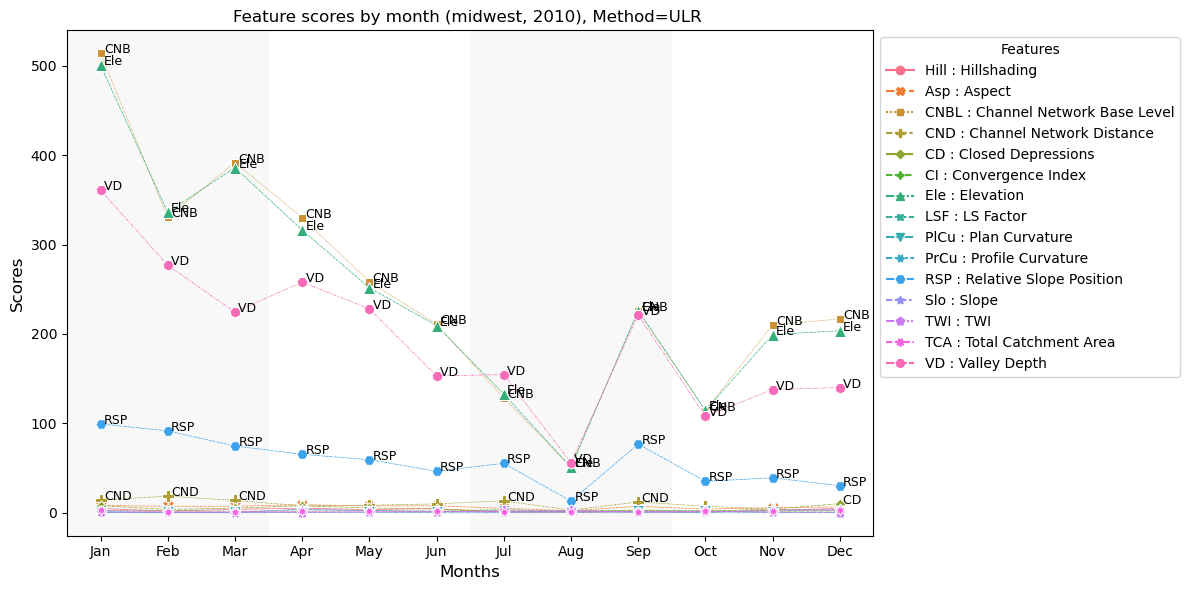

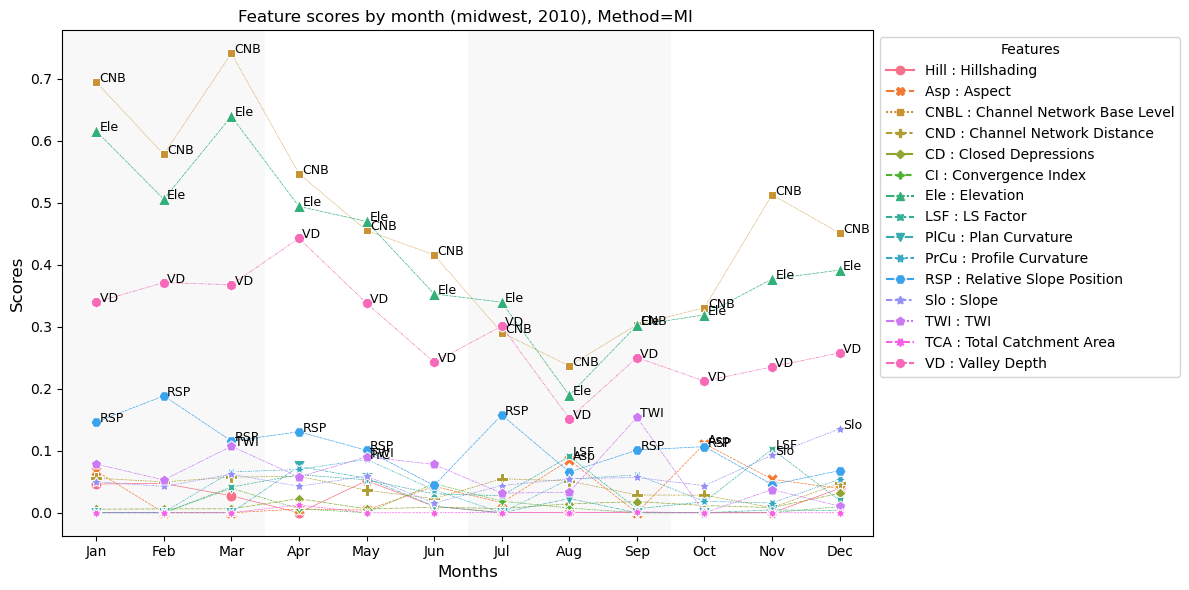

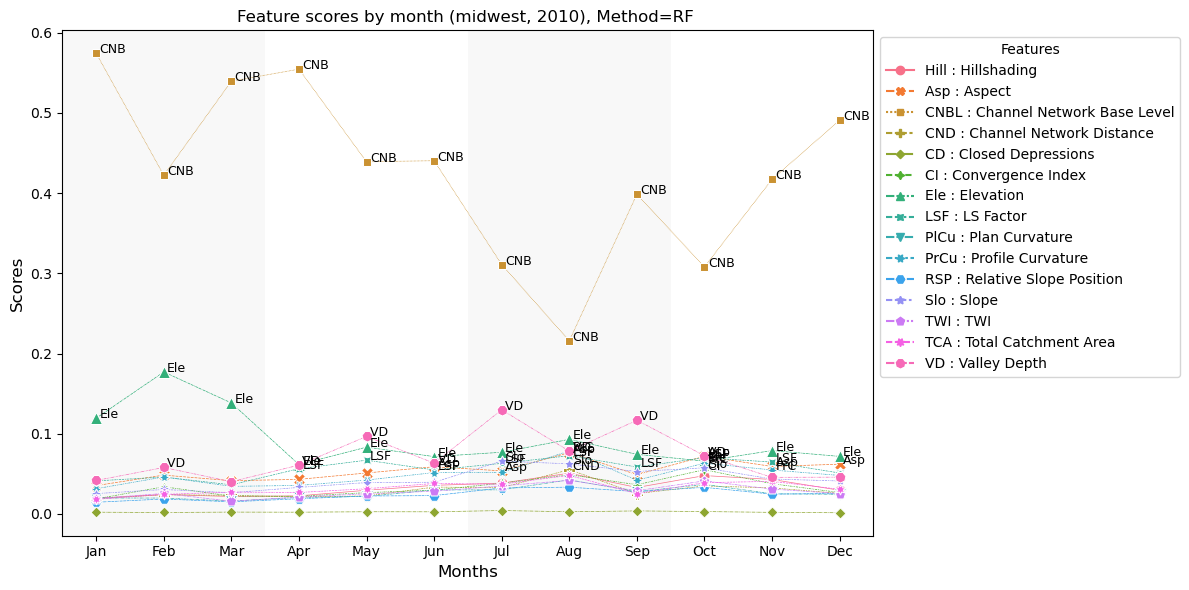

In [14]:
# To compare by methods: find a way to normalize by score
for i, method in enumerate(methods):
    title = 'Feature scores by month ({}, {}), Method={} '.format(region, year, method)
    ranking.plot_scores(labels=feature_names, scores=scores[:, :, i], score_names=month_names, shading=shading, shading_int=shading_int, legend=legend, xlabel='Months', ylim=ylim[i], title=title)

# Recursive Feature Elimination (With Cross-validation)
Returns optimal number of features according to CV results.

In [15]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

# Create the RFE object and compute a cross-validated score.
#reg = SVR(kernel='linear')
reg = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=0)
# The "accuracy" scoring shows the proportion of correct classifications

rfecv = RFECV(
    estimator=reg,
    step=1,
    cv=10,
    scoring='r2',
    min_features_to_select=1
)
rfecv.fit(X_scaled, Y)

# print(rfecv.cv_results_)

print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 15


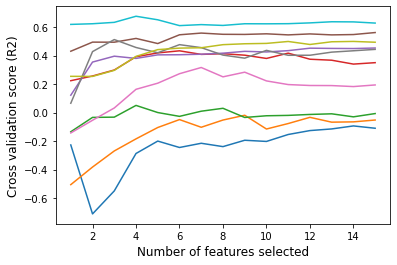

In [16]:
# Plot number of features VS. cross-validation scores
keys = ['split{}_test_score'.format(i) for i in range(10)]
values = np.array([rfecv.cv_results_[key] for key in keys]).T

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (R2)")
plt.plot(range(1, len(values) + 1),values,)
plt.show()

In [17]:
rfecv.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])